In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File("banki_responses.json.bz2", 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
            

201030it [02:28, 1357.62it/s]


In [4]:
data = pd.DataFrame(responses)
data.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [5]:
#группируем данные по значению города
df = data.groupby(['city']).count()
data['city'].value_counts()

г. Москва                      55354
г. Санкт-Петербург             14342
г. Екатеринбург                 2337
г. Новосибирск                  2300
г. Нижний Новгород              1976
                               ...  
г. Киров (Калужская обл.)          1
г. пгт. Белоозерский               1
г. Саратов, Нижний Новгород        1
г. Печоры (Псковская обл.)         1
г. Ставрполь                       1
Name: city, Length: 5823, dtype: int64

In [6]:
#группируем данные по значению банка
df1 = data.groupby(['bank_name']).count()
data['bank_name'].value_counts()

Сбербанк России                                  26327
Альфа-Банк                                       10224
ВТБ 24                                            8185
Русский Стандарт                                  7943
Хоум Кредит Банк                                  7549
                                                 ...  
Юго-Восток                                           1
Венец                                                1
Чувашкредитпромбанк                                  1
Межрегиональный промышленно-строительный банк        1
Град-Банк                                            1
Name: bank_name, Length: 670, dtype: int64

2. Постройте гистограмы длин слов в символах и в словах

In [7]:
import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import pymorphy2
from pymorphy2 import MorphAnalyzer

In [8]:
#делаем предобратобку текста - оставим только русские слова без знаков препинания и цифр, которые переведем в нижний регистр
ru_words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(ru_words.findall(text))
    
def preprocess(text):
    return words_only(text.lower())

In [9]:
data.text = data.text.apply(preprocess)
text = data['text'].tolist()
text[0]

'добрый день я не являюсь клиентом банка и поручителем по кредитному договору а также не являюсь каким либо другим лицом письменно оформившим отношения с банком по поводу урегулирования чьей либо задолженности начиная с марта года начали приходить бесконечные письма из ооо примо коллект на мой адрес город москва уваровский переулок дом квартира с угрозами о возбуждении уголовного дела в отношении гражданина филиппова эдуарда владимировича который уклоняется от уплаты взятых им кредитов договор от года и договор от года со всей ответственностью хочу вас заверить что вышеуказанный гражданин которого вы разыскиваете мне не знаком и никогда в моем адресе не был зарегистрирован каким образом вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор мне по меньшей мере не понятно и почему по вашей милости я должна переживать и бояться за себе и свое имущество письма доставляют мне серьезные неудобства нарушают мои гражданские права а также нарушают закон о защи

In [10]:
#получим корпус всех слов в отзывах
corpus =[]
for word in text:
    corpus += word_tokenize(word)
len(corpus)

35429373

<BarContainer object of 42 artists>

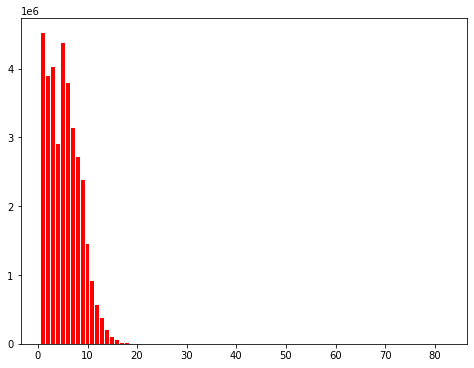

In [11]:
#строим гистограмму длинн всех слов в корпусе
from collections import Counter
length_counts = Counter(len(word) for word in corpus)

from matplotlib.pyplot import figure

figure(figsize=(8, 6))
plt.bar(length_counts.keys(), length_counts.values(),  color='r') 

3. Найдите 10 самых частых

In [12]:
#найдем самые часто встречающиеся слова в корпусе
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 1330550),
 ('и', 1058997),
 ('не', 855335),
 ('на', 707935),
 ('что', 640057),
 ('я', 577500),
 ('с', 464037),
 ('по', 372769),
 ('мне', 320958),
 ('банка', 275906)]

In [13]:
#теперь уберем стоп-слова из отзывов и соберем новый корпус слов
mystopwords = stopwords.words('russian')
mystopwords.extend(['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', 'pуб'])

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [14]:
data.text = data.text.apply(remove_stopwords)
text_filtered = data['text'].tolist()
text_filtered[0]

'добрый день являюсь клиентом банка поручителем кредитному договору являюсь каким либо другим лицом письменно оформившим отношения банком поводу урегулирования чьей либо задолженности начиная марта года начали приходить бесконечные письма ооо примо коллект адрес город москва уваровский переулок дом квартира угрозами возбуждении уголовного дела отношении гражданина филиппова эдуарда владимировича уклоняется уплаты взятых кредитов договор года договор года всей ответственностью хочу заверить вышеуказанный гражданин которого разыскиваете знаком моем адресе зарегистрирован каким образом удостоверившись подлинности документов оформили имя кредитный договор меньшей мере понятно почему вашей милости должна переживать бояться свое имущество письма доставляют серьезные неудобства нарушают мои гражданские права нарушают закон защите персональных данных убедительно прошу прекратить посылать адрес письма угрозами вопросам которым имею отношения случае отклонения моей претензии буду вынуждена обрат

In [15]:
filtered_corpus = []

for word in text_filtered:
    filtered_corpus += word_tokenize(word)

len(filtered_corpus)

21954351

In [16]:
#корпус стал меньше почти на 13.5 млн слов. Найдем новые наиболее используемые слова
freq_dict2 = Counter(filtered_corpus)
freq_dict2.most_common(10)

[('банка', 275906),
 ('банк', 215426),
 ('деньги', 131201),
 ('карту', 105829),
 ('карты', 101821),
 ('кредит', 81136),
 ('день', 76552),
 ('банке', 72169),
 ('заявление', 70423),
 ('очень', 66824)]

In [17]:
# найдем леммы всех слов в отзывах 
def lemmatize(text, pymorphy2_analyzer = MorphAnalyzer()):
    try:
        return " ".join([pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split()]) 
    except:
        return " "


In [18]:
tqdm.pandas()

data.text = data.text.progress_apply(lemmatize)

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [1:30:56<00:00, 28.13it/s]


In [19]:
data.text[456]

'весь член мой семья протяжение последний год доверять свой деньга банк тинькофф данный момент открыто вклад изменение ставка вклад пребывать шок никак вериться банк поступить постоянный верный клиент обидно потерять деньга который рассчитывать обидно кинуть самый порядочный банк наш мнение оставаться надежда июль решение изменение тариф пересмотреть иначе легко предугадать последовать плавный угасание банк испортить вдрыск репутация бренд тинькофф'

In [20]:
#при лемматизации могли появиться новые стоп-слова, которые были пропущены из-за своей формы ранее
data.text = data.text.apply(remove_stopwords)
text_lemma = data['text'].tolist()
text_lemma[456]

'весь член семья протяжение последний год доверять деньга банк тинькофф данный момент открыто вклад изменение ставка вклад пребывать шок никак вериться банк поступить постоянный верный клиент обидно потерять деньга рассчитывать обидно кинуть самый порядочный банк мнение оставаться надежда июль решение изменение тариф пересмотреть иначе легко предугадать последовать плавный угасание банк испортить вдрыск репутация бренд тинькофф'

In [21]:
lemma_corpus = []
for word in text_lemma:
    lemma_corpus += word_tokenize(word)

len(lemma_corpus)

20841522

In [22]:
#корпус стал меньше еще на 1 млн стоп-слов. Определяем наиболее часто встречающиеся
freq_dict3 = Counter(lemma_corpus)
freq_dict3.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('деньга', 179819),
 ('день', 173116),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894),
 ('сказать', 114440)]

In [23]:
from contextlib import closing

In [24]:
#при помощи pymorphy отбираем только существительные и опреляем частоту их использования
nouns_corpus = []
pymorphy2_analyzer = MorphAnalyzer()
with closing(tqdm(total=len(lemma_corpus))) as pbar:
    for i in range (len(lemma_corpus)):
        lemma = pymorphy2_analyzer.parse(lemma_corpus[i])
        if lemma[0].tag.POS == 'NOUN':
            nouns_corpus.append(lemma[0].normal_form)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████| 20841522/20841522 [1:21:28<00:00, 4263.36it/s]


In [25]:
freq_dict4 = Counter(nouns_corpus)
freq_dict4.most_common(10)

[('банк', 668589),
 ('карта', 335000),
 ('деньга', 179819),
 ('день', 173116),
 ('кредит', 156177),
 ('отделение', 144050),
 ('клиент', 136892),
 ('сотрудник', 134168),
 ('счёт', 126894),
 ('сумма', 111232)]

Кривая Ципфа

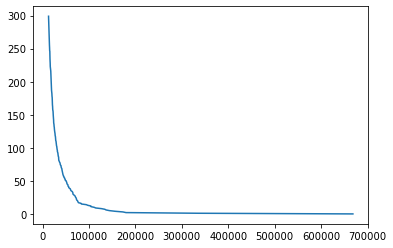

In [26]:
#строим график зависимости ранга слова в корпусе от его частоты использования. Для этого используем корпус лемм

import matplotlib.pyplot as plt
%matplotlib inline


freqs = list(freq_dict3.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

Закон Хипса

In [27]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(data.iterrows(), total = len(data)):
    tokens = word_tokenize(row['text'])
    cnt.update(tokens)
    n_words.append(len(cnt))
   # n_tokens.append(sum(cnt.values()))
    n_tokens.append(sum(list(cnt.values())))

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [16:41<00:00, 153.32it/s]


<Figure size 576x432 with 0 Axes>

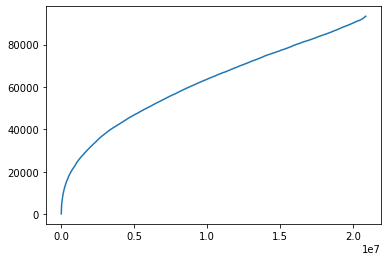

In [28]:
figure(figsize=(8, 6))
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

Ответьте на следующие вопросы:
какое слово встречается чаще, "сотрудник" или "клиент"?
сколько раз встречается слова "мошенничество" и "доверие"?

In [29]:
if dict(freq_dict3)['сотрудник'] > dict(freq_dict3)['клиент']: print ('слово сотрудник встречается чаще')
else: print('слово клиент встречается чаще')

слово клиент встречается чаще


In [30]:
print(f"слово мошенничество встретилось {dict(freq_dict3)['мошенничество']} раз")
print(f"слово доверие встретилось {dict(freq_dict3)['доверие']} раз")

слово мошенничество встретилось 3244 раз
слово доверие встретилось 2108 раз


В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
data_1 = data[data['rating_grade'] == 1]
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47387 entries, 19 to 153497
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                39855 non-null  object 
 1   rating_not_checked  47387 non-null  bool   
 2   title               47387 non-null  object 
 3   num_comments        47387 non-null  int64  
 4   bank_license        47387 non-null  object 
 5   author              47382 non-null  object 
 6   bank_name           47387 non-null  object 
 7   datetime            47387 non-null  object 
 8   text                47387 non-null  object 
 9   rating_grade        47387 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 3.7+ MB


In [33]:
text_1 = data_1['text'].tolist()
text_1[0]

'открыть вклад счёт плюс зарплатный карта рубль сегодня прийти указанный отделение цель пополнить долларовый сч дать операционист паспорт зарплатный карта окошко написать приготовить карта подтверждение операция подобный потребовать сказать нужно положить деньга долларовый счёт операционист вс взять делать крутило вертел вставить карта терминал сказать ввести пин век л пин получить ответ чек написать доллар внести сч карта рубль вопрос банк риторический понимать нужно сознательно проводить операция угол маленький квартал курс ма валюта выше рубль действительно хотеть совершить хитрый операция выгодный сделать шаг заработать около рубль просто внести рубль сч карта банкомат далее долгий около час выяснение отношение операционист видимо начальник попытка отменить первый транзакция п сойтись компенсировать курсовой разница зачисление доллар рубла вую карта руб доллар слово операционист курс покупка валюта руб доллар купить наличный доллар положить долларовый сч попросить указать чек курс 

In [64]:
full_corpus_1 = []

for i in range (0, len(text_1)):
    corpus = word_tokenize(text_1[i])
    full_corpus_1 += corpus

In [36]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(full_corpus_1)


In [49]:
idf = vectorizer.idf_
results = dict(zip(vectorizer.get_feature_names(), idf))
key_words = {k: v for k, v in sorted(results.items(), key=lambda item: item[1],reverse=False)}
print (list(key_words.keys())[0:10])

['банк', 'карта', 'деньга', 'день', 'отделение', 'кредит', 'сотрудник', 'счёт', 'клиент', 'сказать']


In [43]:
key_words

{'банк': 4.483298007825809,
 'карта': 5.159679993973404,
 'деньга': 5.670451034233079,
 'день': 5.725379649729874,
 'отделение': 5.826300465323919,
 'кредит': 5.9359169150044675,
 'сотрудник': 5.943399700111702,
 'счёт': 6.0126824256962195,
 'клиент': 6.0480685006028185,
 'сказать': 6.050670155378998,
 'заявление': 6.11259025882666,
 'сумма': 6.216977765476888,
 'вопрос': 6.364144183973696,
 'год': 6.384352170643756,
 'время': 6.399929684402486,
 'ответ': 6.453030843491745,
 'получить': 6.458891158319581,
 'звонить': 6.535983662308794,
 'офис': 6.574003649424433,
 'телефон': 6.588179167533391,
 'кредитный': 6.593913355667328,
 'договор': 6.603178905303743,
 'дать': 6.620596265427256,
 'платёж': 6.624727964368504,
 'позвонить': 6.635528339360965,
 'банкомат': 6.637642026265515,
 'написать': 6.650457108003698,
 'сбербанк': 6.661424450920453,
 'месяц': 6.686579560168871,
 'номер': 6.687730925060331,
 'ваш': 6.705243244211361,
 'говорить': 6.740754803391958,
 'работать': 6.759485664096668,

In [67]:
vectorizer = TfidfVectorizer(ngram_range = (2,2))
X = vectorizer.fit_transform(text_1)


In [68]:
idf = vectorizer.idf_
results = dict(zip(vectorizer.get_feature_names(), idf))
key_words = {k: v for k, v in sorted(results.items(), key=lambda item: item[1],reverse=False)}
print (list(key_words.keys())[0:10])

['сотрудник банк', 'написать заявление', 'отделение банк', 'кредитный карта', 'денежный средство', 'клиент банк', 'горячий линия', 'добрый день', 'рабочий день', 'следующий день']


In [50]:
data_5 = data[data['rating_grade'] == 5]
data_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14713 entries, 98 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                10511 non-null  object 
 1   rating_not_checked  14713 non-null  bool   
 2   title               14713 non-null  object 
 3   num_comments        14713 non-null  int64  
 4   bank_license        14713 non-null  object 
 5   author              14710 non-null  object 
 6   bank_name           14713 non-null  object 
 7   datetime            14713 non-null  object 
 8   text                14713 non-null  object 
 9   rating_grade        14713 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 1.1+ MB


In [51]:
data_5.text = data_5.text.apply(preprocess)
text_5 = data_5['text'].tolist()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [52]:
full_corpus_5 = []

for i in range (0, len(text_5)):
    corpus = word_tokenize(text_5[i])
    full_corpus_5 += corpus

In [53]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(full_corpus_5)


In [55]:
idf = vectorizer.idf_
results = dict(zip(vectorizer.get_feature_names(), idf))
key_words = {k: v for k, v in sorted(results.items(), key=lambda item: item[1],reverse=False)}
print (list(key_words.keys())[0:10])

['банк', 'карта', 'очень', 'день', 'кредит', 'клиент', 'отделение', 'сотрудник', 'деньга', 'вклад']


In [56]:
key_words

{'банк': 4.372713329737448,
 'карта': 5.32813294037284,
 'очень': 5.798789389105334,
 'день': 5.940142173160657,
 'кредит': 5.941096616902581,
 'клиент': 5.9629286268160975,
 'отделение': 5.98563185318175,
 'сотрудник': 6.08502839861835,
 'деньга': 6.093290444679341,
 'вклад': 6.099897925705968,
 'год': 6.161599321611582,
 'вопрос': 6.253015992069128,
 'время': 6.261783999866004,
 'сч': 6.263303526066298,
 'офис': 6.276570380517079,
 'работа': 6.3901374340712715,
 'обслуживание': 6.5038574952998385,
 'сказать': 6.5512559784034625,
 'проблема': 6.568851740293842,
 'документ': 6.635713953563839,
 'спасибо': 6.640876587642647,
 'получить': 6.645323015599781,
 'кредитный': 6.6454715708997645,
 'хотеть': 6.669833678018005,
 'работать': 6.674105232949265,
 'сумма': 6.729906617665463,
 'очередь': 6.756775861868799,
 'минута': 6.759436322367202,
 'интернет': 6.772171078918707,
 'быстро': 6.788492420482811,
 'решить': 6.793647956906399,
 'плат': 6.861361741290247,
 'весь': 6.914558725135562,
 '

In [69]:
vectorizer = TfidfVectorizer(ngram_range = (2,2))
X = vectorizer.fit_transform(text_5)

In [70]:
idf = vectorizer.idf_
results = dict(zip(vectorizer.get_feature_names(), idf))
key_words = {k: v for k, v in sorted(results.items(), key=lambda item: item[1],reverse=False)}
print (list(key_words.keys())[0:10])

['сотрудник банк', 'интернет банк', 'кредитный карта', 'клиент банк', 'являться клиент', 'следующий день', 'отделение банк', 'добрый день', 'очень удобно', 'очень довольный']


### Часть 2. Тематическое моделирование

In [71]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities
from gensim.models import lsimodel

In [72]:
#преобразуем отзывы в необходимый для gensim формат
texts = [text.split() for text in data.text]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [73]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [74]:
#строим модель на 20 тем
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

In [75]:
lsi.show_topics(5)

[(0,
  '0.199*"карта" + 0.137*"кредит" + 0.118*"деньга" + 0.112*"заявление" + 0.109*"счёт" + 0.104*"банкомат" + 0.103*"вклад" + 0.103*"отделение" + 0.099*"сбербанк" + 0.098*"сумма"'),
 (1,
  '-0.370*"вклад" + 0.362*"кредит" + -0.218*"банкомат" + -0.176*"карта" + 0.170*"страховка" + 0.147*"платёж" + 0.146*"задолженность" + 0.141*"погашение" + -0.124*"деньга" + 0.117*"звонок"'),
 (2,
  '-0.518*"вклад" + 0.270*"банкомат" + 0.210*"карта" + 0.181*"сбербанк" + 0.132*"заявление" + -0.121*"кредит" + -0.120*"договор" + 0.118*"операция" + -0.117*"очередь" + 0.114*"средство"'),
 (3,
  '-0.257*"вклад" + -0.220*"сумма" + 0.196*"номер" + -0.190*"руб" + 0.177*"заявка" + -0.159*"погашение" + -0.158*"платёж" + 0.151*"звонок" + -0.150*"договор" + -0.145*"процент"'),
 (4,
  '0.306*"вклад" + -0.292*"карта" + 0.272*"номер" + -0.214*"страховка" + 0.194*"звонок" + -0.191*"заявка" + -0.139*"лимит" + 0.139*"ваш" + 0.139*"телефон" + -0.135*"кредитный"')]

In [76]:
#для сравнения уменьшим в два раза количество тем
lsi_1 = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)
lsi_1.show_topics(5)

[(0,
  '0.199*"карта" + 0.136*"кредит" + 0.118*"деньга" + 0.112*"заявление" + 0.110*"счёт" + 0.103*"банкомат" + 0.103*"вклад" + 0.103*"отделение" + 0.099*"сбербанк" + 0.099*"сумма"'),
 (1,
  '-0.415*"вклад" + 0.357*"кредит" + -0.191*"банкомат" + 0.163*"страховка" + -0.157*"карта" + 0.154*"платёж" + 0.149*"задолженность" + 0.140*"погашение" + -0.111*"деньга" + 0.111*"погасить"'),
 (2,
  '-0.490*"вклад" + 0.270*"банкомат" + 0.225*"карта" + 0.203*"сбербанк" + -0.155*"кредит" + -0.131*"договор" + 0.128*"заявление" + 0.127*"операция" + 0.117*"средство" + 0.116*"деньга"'),
 (3,
  '-0.265*"вклад" + -0.215*"сумма" + 0.204*"заявка" + 0.191*"номер" + -0.183*"руб" + -0.159*"платёж" + -0.155*"погашение" + -0.152*"договор" + 0.145*"звонок" + -0.145*"рубль"'),
 (4,
  '-0.450*"карта" + 0.304*"банкомат" + -0.197*"лимит" + -0.188*"кредитный" + 0.162*"номер" + 0.128*"терминал" + 0.127*"деньга" + 0.122*"купюра" + 0.121*"звонок" + -0.115*"комиссия"')]

In [77]:
#выберем только те темы, в которых встречается "сбербанк"
topics = lsi_1.show_topics(10)
sber_topics = [topic for topic in topics if "сбербанк" in topic[1]]

sber_topics

[(0,
  '0.199*"карта" + 0.136*"кредит" + 0.118*"деньга" + 0.112*"заявление" + 0.110*"счёт" + 0.103*"банкомат" + 0.103*"вклад" + 0.103*"отделение" + 0.099*"сбербанк" + 0.099*"сумма"'),
 (2,
  '-0.490*"вклад" + 0.270*"банкомат" + 0.225*"карта" + 0.203*"сбербанк" + -0.155*"кредит" + -0.131*"договор" + 0.128*"заявление" + 0.127*"операция" + 0.117*"средство" + 0.116*"деньга"'),
 (6,
  '0.274*"сбербанк" + 0.201*"заявление" + 0.186*"заявка" + 0.182*"страховка" + -0.181*"платёж" + 0.167*"страхование" + 0.157*"документ" + 0.151*"денежный" + -0.135*"задолженность" + 0.135*"средство"'),
 (9,
  '-0.469*"кошелёк" + -0.343*"киви" + -0.229*"вклад" + 0.209*"сбербанк" + -0.150*"страховка" + -0.147*"идентификация" + -0.131*"поддержка" + -0.128*"заблокировать" + -0.119*"терминал" + 0.118*"курс"')]

In [78]:
#выберем только те темы, в которых встречается "альфа-банк"
topics = lsi.show_topics(20)
alfa_topics = [topic for topic in topics if "альфа" in topic[1]]

alfa_topics

[(8,
  '0.276*"банкомат" + 0.224*"страховка" + -0.208*"сбербанк" + -0.180*"платёж" + 0.175*"альфа" + 0.171*"страхование" + 0.149*"комиссия" + 0.143*"услуга" + -0.126*"заявление" + -0.125*"погашение"'),
 (13,
  '-0.291*"кошелёк" + -0.220*"киви" + 0.211*"смс" + 0.194*"погашение" + 0.193*"услуга" + 0.175*"досрочный" + -0.160*"сбербанк" + 0.149*"альфа" + -0.141*"деньга" + 0.141*"претензия"'),
 (14,
  '0.344*"терминал" + 0.342*"руб" + 0.246*"комиссия" + -0.199*"кошелёк" + 0.182*"заявка" + -0.148*"банкомат" + -0.134*"альфа" + -0.131*"заблокировать" + 0.118*"касса" + 0.114*"лимит"'),
 (19,
  '0.348*"альфа" + 0.241*"терминал" + -0.234*"платёж" + -0.222*"персональный" + 0.191*"справка" + -0.183*"обработка" + -0.154*"данные" + -0.153*"банкомат" + 0.148*"номер" + -0.145*"согласие"')]

### Часть 3. Классификация текстов

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [80]:
#созададим датафрейм для классификации - возьмем 100отзывов с рейтингом "5" и 170 отзывов с рейтингом "1"

data_clf = pd.concat([data_5[:100], data_1[:170]])
data_clf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 98 to 924
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                270 non-null    object 
 1   rating_not_checked  270 non-null    bool   
 2   title               270 non-null    object 
 3   num_comments        270 non-null    int64  
 4   bank_license        270 non-null    object 
 5   author              270 non-null    object 
 6   bank_name           270 non-null    object 
 7   datetime            270 non-null    object 
 8   text                270 non-null    object 
 9   rating_grade        270 non-null    float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 21.4+ KB


In [81]:
#разделим выборку
from sklearn.model_selection import train_test_split
X = data_clf.text
y = data_clf["rating_grade"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [82]:
#получим baseline на униграммах
clf_uni = Pipeline([
     ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))),
     ('clf', RandomForestClassifier())
 ])

In [83]:
clf_uni.fit(X_train, y_train)
y_pred_uni= clf_uni.predict(X_test)
print(f" f1_score = {f1_score(y_test, y_pred_uni)}")
print(f" accuracy_score = {accuracy_score(y_test, y_pred_uni)}")

 f1_score = 0.888888888888889
 accuracy_score = 0.8444444444444444


In [84]:
#получим baseline на биграммах
clf_bi = Pipeline([
     ('vect', CountVectorizer(analyzer = 'word', ngram_range=(2,2))),
     ('clf', RandomForestClassifier()),
 ])

In [85]:
clf_bi.fit(X_train, y_train)
y_pred_bi= clf_bi.predict(X_test)
print(f" f1_score = {f1_score(y_test, y_pred_bi)}")
print(f" accuracy_score = {accuracy_score(y_test, y_pred_bi)}")

 f1_score = 0.7671232876712328
 accuracy_score = 0.6222222222222222


In [86]:
#получим baseline на триграммах
clf_tri = Pipeline([
     ('vect', CountVectorizer(analyzer = 'word', ngram_range=(3,3))),
     ('clf', RandomForestClassifier()),
 ])

In [87]:
clf_tri.fit(X_train, y_train)
y_pred_tri= clf_tri.predict(X_test)
print(f" f1_score = {f1_score(y_test, y_pred_tri)}")
print(f" accuracy_score = {accuracy_score(y_test, y_pred_tri)}")

 f1_score = 0.7671232876712328
 accuracy_score = 0.6222222222222222


In [88]:
#получим baseline на символьных униграммах
clf_char = Pipeline([
     ('vect', CountVectorizer(analyzer = 'char', ngram_range=(1,1))),
     ('clf', RandomForestClassifier())
 ])

In [89]:
clf_char.fit(X_train, y_train)
y_pred_char= clf_char.predict(X_test)
print(f" f1_score = {f1_score(y_test, y_pred_char)}")
print(f" accuracy_score = {accuracy_score(y_test, y_pred_char)}")

 f1_score = 0.7627118644067797
 accuracy_score = 0.6888888888888889


In [90]:
clf_svd = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=5, 
                        random_state=42)), 
    ('clf', RandomForestClassifier())
])


In [91]:
clf_svd.fit(X_train, y_train)
y_pred_svd = clf_svd.predict(X_test)
print(f" f1_score = {f1_score(y_test, y_pred_svd)}")
print(f" accuracy_score = {accuracy_score(y_test, y_pred_svd)}")

 f1_score = 0.8166666666666667
 accuracy_score = 0.7555555555555555


In [92]:
clf_lda = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'word', ngram_range=(1,1))), 
    ('tfidf', TfidfTransformer()), 
    ('lda', LatentDirichletAllocation(n_components=2, random_state=0))
])


In [93]:
clf_lda.fit(X_train, y_train)
y_pred_lda = clf_lda.transform(X_test)
y_pred_lda

array([[0.93709428, 0.06290572],
       [0.90920776, 0.09079224],
       [0.90215024, 0.09784976],
       [0.89829088, 0.10170912],
       [0.92793848, 0.07206152],
       [0.95170535, 0.04829465],
       [0.93909023, 0.06090977],
       [0.93395305, 0.06604695],
       [0.93595095, 0.06404905],
       [0.92158013, 0.07841987],
       [0.91875956, 0.08124044],
       [0.9458947 , 0.0541053 ],
       [0.90956158, 0.09043842],
       [0.93706053, 0.06293947],
       [0.9275489 , 0.0724511 ],
       [0.93672174, 0.06327826],
       [0.92957264, 0.07042736],
       [0.92790895, 0.07209105],
       [0.92956597, 0.07043403],
       [0.90701972, 0.09298028],
       [0.92835518, 0.07164482],
       [0.92601188, 0.07398812],
       [0.9273428 , 0.0726572 ],
       [0.92209079, 0.07790921],
       [0.92394703, 0.07605297],
       [0.93378353, 0.06621647],
       [0.9446256 , 0.0553744 ],
       [0.93837428, 0.06162572],
       [0.94249405, 0.05750595],
       [0.93603064, 0.06396936],
       [0.